# Bayesian Seizure Likelihood Estimation

In [71]:
import pyro
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import torch
import zarr

from msc.data_utils import get_dataset, get_sample_rate_from_ds, get_config_dataset, get_sample_times, get_event_sample_times
from msc.plot_utils import plot_sample, set_size
from msc.time_utils import uSEC, SEC
from msc import config

plt.style.use(['science', 'no-latex'])

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sample space

In [4]:
# eeg plot example
# seizure sequence plot example
ds = get_config_dataset()

In [5]:
cache_zarr = zarr.open(f"{config['path']['data_v1']}/cache.zarr")
ds_zarr = cache_zarr[config['dataset_id']]

In [6]:
mean = ds_zarr['mu']
std = ds_zarr['std']

In [7]:
mean, std

(<zarr.core.Array '/I004_A0003_D001/mu' (2,) float64>,
 <zarr.core.Array '/I004_A0003_D001/std' (2,) float64>)

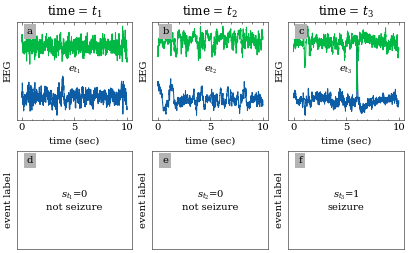

In [132]:
fig, axs = plt.subplot_mosaic([['a', 'b', 'c'], ['d', 'e', 'f']], constrained_layout=True, figsize=set_size(409))

sfreq = get_sample_rate_from_ds(ds)
sample_times = [300000, 3000000, 1247349926757/1e6]

for label, ax in axs.items():
    if label == 'a':
        sample = ds.get_data(sample_times[0], 10, np.arange(2))
        sample = (sample - np.mean(sample, axis=0)) / np.std(sample, axis=0)
        plot_sample(np.arange(sample.shape[0]) / sfreq, sample, ax=ax)
        ax.annotate("$e_{t_1}$", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        ax.set_title('time = $t_1$')

    elif label == 'b':
        sample = ds.get_data(sample_times[1], 10, np.arange(2))
        sample = (sample - np.mean(sample, axis=0)) / np.std(sample, axis=0)
        plot_sample(np.arange(sample.shape[0]) / sfreq, sample, ax=ax)
        ax.annotate("$e_{t_2}$", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        ax.set_title('time = $t_2$')
        
    elif label == 'c':
        sample = ds.get_data(sample_times[2], 10, np.arange(2))
        sample = (sample - np.mean(sample, axis=0)) / np.std(sample, axis=0)
        plot_sample(np.arange(sample.shape[0]) / sfreq, sample, ax=ax)
        ax.annotate("$e_{t_3}$", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        ax.set_title('time = $t_3$')


    elif label == 'd':
        ax.annotate("$s_{t_1}$=0\nnot seizure", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        # ax.set_xlabel("$s_t$")
        ax.set_ylabel("event label")
        ax.set_xticks([])
        ax.set_yticks([])
        

    elif label == 'e':
        ax.annotate("$s_{t_2}$=0\nnot seizure", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        # ax.set_xlabel("$s_t$")
        ax.set_ylabel("event label")
        ax.set_xticks([])
        ax.set_yticks([])

    elif label == 'f':
        ax.annotate("$s_{t_3}$=1\nseizure", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        # ax.set_xlabel("$s_t$")
        ax.set_ylabel("event label")
        ax.set_xticks([])
        ax.set_yticks([])

    else:
        ax.annotate("hello", xy=(0, 0))

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

plt.savefig(f"{config['path']['figures']}/bsle_intro/sample_space.pdf", bbox_inches='tight')

In [99]:
sample.shape

(3997, 2)

In [94]:
np.mean(sample, axis=0)

array([-16.38478859, -18.54841131])

In [92]:
sample / np.std(sample, axis=0)

array([[-0.82398804, -0.6434087 ],
       [-0.79557466, -0.49201842],
       [-0.79557466, -0.54878977],
       ...,
       [-0.56826762, -1.00296062],
       [-0.4404074 , -0.81372277],
       [-0.31254719, -0.43524706]])

In [46]:
axs.values()

dict_values([<AxesSubplot:label='a', xlabel='time (s)'>, <AxesSubplot:label='b', xlabel='time (s)'>, <AxesSubplot:label='c', xlabel='time (s)'>, <AxesSubplot:label='d', xlabel='time (s)'>])

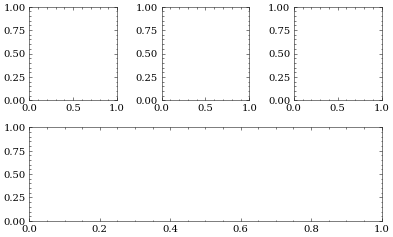

In [28]:
sample_times = [100000, 1000000, 1247349926757/1e6]
fig, axes = plt.subplots(2, 3, figsize=set_size(409))
gs = axes[1,1].get_gridspec()
for ax in axes[1]:
    ax.remove()
axbig = fig.add_subplot(gs[1:, :])
fig.tight_layout()
plt.savefig(f"{config['path']['figures']}/bsle_intro/sample_space.pdf", bbox_inches='tight')

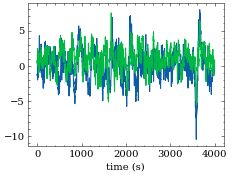

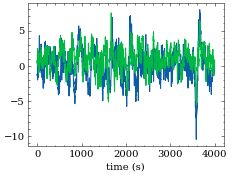

In [19]:
sample = ds.get_data(100000, 10, np.arange(2))
sample = (sample - mean) / std
plot_sample(np.arange(sample.shape[0]), sample.T)

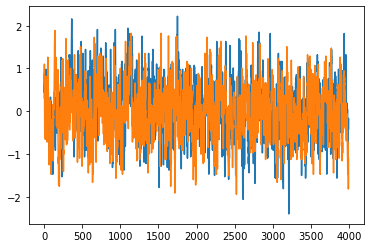

In [9]:
sample = ds.get_data(1000000, 10, np.arange(2))
sample = (sample - mean) / std
plt.plot(sample)

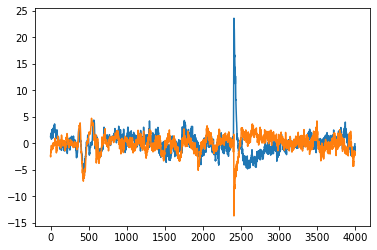

In [10]:
sample = ds.get_data(1247349926757/1e6, 10, np.arange(2))
sample = (sample - mean) / std
plt.plot(sample)

In [11]:
ds.get_annotations('seizures')

[annotation(1520854): Seizure(1218321606445,1218321606445),
 annotation(1520835): Seizure(1247349926757,1247349926757),
 annotation(1520861): Seizure(1264605761718,1264605761718),
 annotation(1520853): Seizure(1298929248047,1298929248047),
 annotation(1520838): Seizure(3723396582031,3723396582031),
 annotation(1520845): Seizure(3740143920898,3740143920898),
 annotation(1520818): Seizure(3757552905273,3757552905273),
 annotation(1520832): Seizure(3777676538086,3777676538086),
 annotation(1520817): Seizure(3792052563476,3792052563476),
 annotation(1520842): Seizure(3801642919922,3801642919922),
 annotation(1520841): Seizure(3812543554687,3812543554687),
 annotation(1520827): Seizure(3823004760742,3823004760742),
 annotation(1520830): Seizure(3835018481445,3835018481445),
 annotation(1520857): Seizure(3850369458007,3850369458007),
 annotation(1520819): Seizure(6105192285156,6105192285156),
 annotation(1520833): Seizure(6122403076172,6122403076172),
 annotation(1520822): Seizure(6140418652

## circular Gaussian prior

In [12]:
def model():
    

SyntaxError: unexpected EOF while parsing (3468611879.py, line 2)

Forward-simulation of circular Gaussian distribution

## Build the inference engine

## Run the inference engine

## Plot the inference engine results

## Empirical events - subject_id

## Plot the inference of the empirical data

## Sampling the Cox Process

## Inferring the Latent Intensity Function

## Checking the Model